## Setup

In [1]:
# Imports

# Standard library
import random
import sqlite3

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.stats import chi2_contingency

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
# Instanciate: Vectorizer, PCA, KMeans, Classifiers

# Vectorizers
vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Dim Reduction
pca = PCA(n_components=2)

# Clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Classifier Param Testing
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 50],
    'max_features': ['sqrt', 0.2, 0.5],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42
)

best_rf_params = {
    'n_estimators': 100,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': None,
    'class_weight': 'balanced'
}

# Classifiers
clf_NB = MultinomialNB()
clf_RF = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

In [3]:
# Helper Functions
def print_lists_side_by_side(positive_list, negative_list, number, type):
    print(f"\n=== {type} Component #{number} ===\n")
    print(f"{'Negative':<30} {'Positive'}")
    print("-" * 50)

    # Find the longer of the two lists
    max_len = max(len(positive_list), len(negative_list))

    for i in range(max_len):
        neg_item = negative_list[i] if i < len(negative_list) else ""
        pos_item = positive_list[i] if i < len(positive_list) else ""
        print(f"{i+1:>2}: {neg_item:<27} {pos_item}")

In [4]:
# Build DF from DB, Remove NULL entries
conn = sqlite3.connect("../WELFake_Dataset.db")
df = pd.read_sql(
    "SELECT * FROM WELFake_Dataset WHERE title IS NOT NULL", 
    conn,  
    index_col="id"
)

In [5]:
# Split DF
titles = df['title']
labels = df['label']
titles_train, titles_test, labels_train, labels_test = train_test_split(
    titles,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

In [6]:
# Check DF
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 71576 entries, 1 to 72134
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    71537 non-null  object
 2   label   71576 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


## Visualize Data with PCA

In [7]:
# Get and Check Sample

# Get Data Sample
sample = df.sample(n=10000, random_state=42)

titles_sample = sample['title'].tolist()
labels_sample = sample['label'].tolist()

# Check with Chi-Squared
sample_fake = sum([1 for label in labels_sample if label == "1"])
sample_real = sum([1 for label in labels_sample if label == "0"])

full_fake = sum([1 for label in labels if label == "1"])
full_real = sum([1 for label in labels if label == "0"])

contingency = np.array([
    [sample_fake, sample_real],
    [full_fake, full_real]
])

chi2, p, _, _ = chi2_contingency(contingency)

print(f"Chi-squared test p-value: {p:.5f}")

Chi-squared test p-value: 0.67179


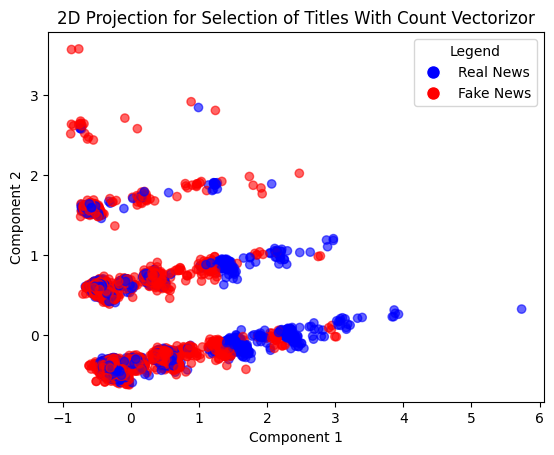

In [8]:
# Visualize Data with PCA (With Count)

# Vectorize with Count
x_sample = vectorizer.fit_transform(titles_sample).toarray()

# Reduce
x_pca = pca.fit_transform(x_sample)

# Plot
colors = [ "blue" if label=='0' else "red" for label in labels_sample ]

plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=colors,
    alpha=0.6
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Real News', 
           markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fake News', 
           markerfacecolor='red', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Projection for Selection of Titles With Count Vectorizor")
plt.show()

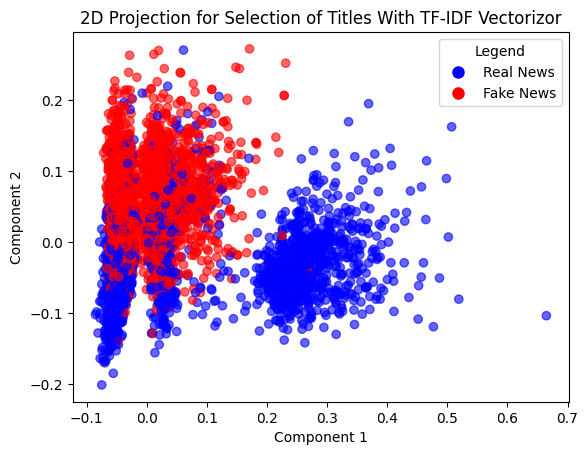

In [9]:
# Visualize Data with PCA (With Count)

# Get Data Sample
sample = df.sample(n=10000, random_state=42)

titles_sample = sample['title'].tolist()
labels_sample = sample['label'].tolist()

# Vectorize
x_sample = tfidf_vectorizer.fit_transform(titles_sample).toarray()

# Reduce
x_pca = pca.fit_transform(x_sample)

# Plot
colors = [ "blue" if label=='0' else "red" for label in labels_sample ]

plt.scatter(
    x_pca[:, 0],
    x_pca[:, 1],
    c=colors,
    alpha=0.6
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Real News', 
           markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Fake News', 
           markerfacecolor='red', markersize=10)
]

plt.legend(handles=legend_elements, title="Legend")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D Projection for Selection of Titles With TF-IDF Vectorizor")
plt.show()

In [10]:
# Words Driving PC1

# Words in your CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# PCA components
components = pca.components_

# Top words contributing to PC1 (positive)
pc1_top_indices_p = components[0].argsort()[::-1][:20]
top_words_pc1_p = feature_names[pc1_top_indices_p]

# Top words contributing to PC1 (negative)
pc1_top_indices_n = components[0].argsort()[:20]
top_words_pc1_n = feature_names[pc1_top_indices_n]

print_lists_side_by_side(top_words_pc1_p,top_words_pc1_n,1, "PCA")


=== PCA Component #1 ===

Negative                       Positive
--------------------------------------------------
 1: video                       the
 2: to                          new
 3: trump                       york
 4: says                        times
 5: on                          and
 6: house                       of
 7: for                         donald
 8: with                        your
 9: breitbart                   is
10: watch                       in
11: white                       briefing
12: obama                       how
13: after                       an
14: korea                       evening
15: iran                        today
16: russia                      at
17: over                        what
18: he                          it
19: bill                        california
20: senate                      world


In [11]:
# Words Driving PC2

# Top words contributing to PC2 (positive)
pc2_top_indices_p = components[1].argsort()[::-1][:20]
top_words_pc2_p = feature_names[pc2_top_indices_p]

# Top words contributing to PC2 (negative)
pc2_top_indices_n = components[1].argsort()[:20]
top_words_pc2_n = feature_names[pc2_top_indices_n]

print_lists_side_by_side(top_words_pc2_p,top_words_pc2_n,2, "PCA")


=== PCA Component #2 ===

Negative                       Positive
--------------------------------------------------
 1: to                          trump
 2: new                         video
 3: says                        the
 4: york                        is
 5: house                       hillary
 6: times                       and
 7: in                          donald
 8: north                       for
 9: korea                       clinton
10: china                       of
11: bill                        it
12: white                       watch
13: senate                      his
14: eu                          he
15: iran                        about
16: russia                      just
17: court                       this
18: talks                       president
19: deal                        why
20: tax                         you


## Visualize Data with Cluster Analysis

[np.float64(0.3126957359672368), np.float64(0.8634788634788635), np.float64(0.022271714922048998), np.float64(0.7180729760547321)]


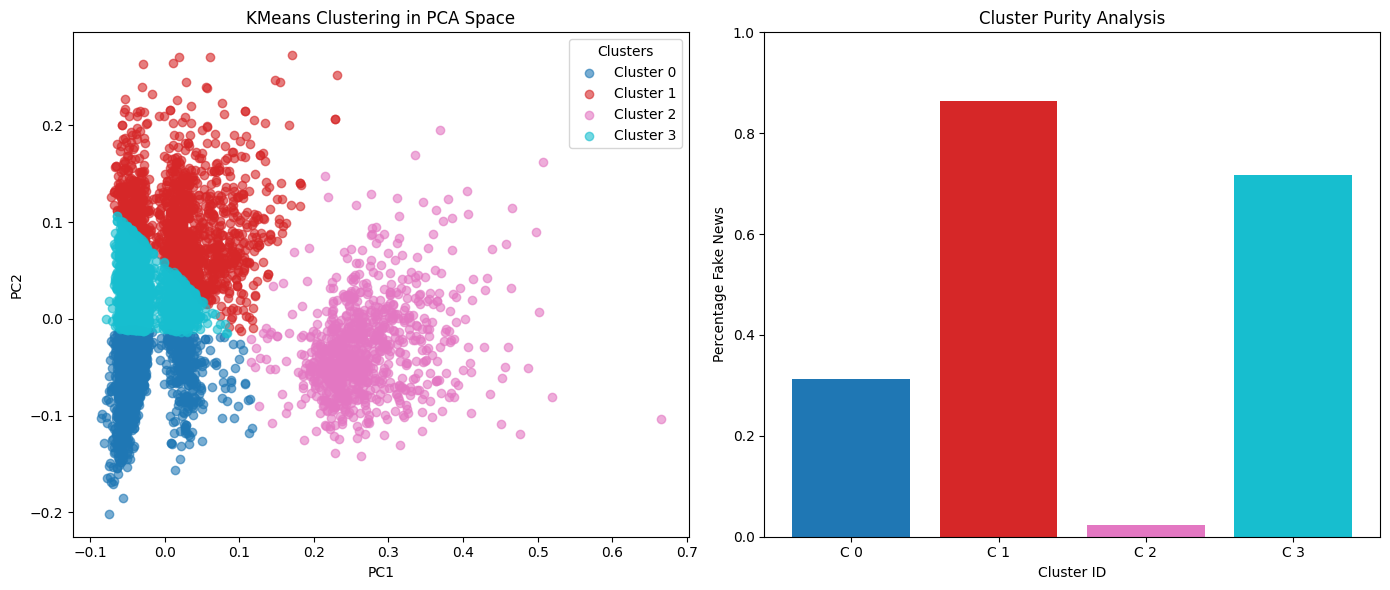

In [12]:
# Perform Cluster Analysis

# Use modern colormap API
cmap = plt.get_cmap("tab10", num_clusters)

# Run KMeans clustering
cluster_labels = kmeans.fit_predict(x_pca)

# Calculate fake news percentage in each cluster
counts = []
for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    labels_in_cluster = np.array(labels_sample)[mask]
    fake_pct = np.sum(labels_in_cluster == '1') / len(labels_in_cluster)
    counts.append(fake_pct)
print(counts)

# Create figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot in first subplot
ax = axes[0]

for cluster_id in np.unique(cluster_labels):
    mask = cluster_labels == cluster_id
    ax.scatter(
        x_pca[mask, 0],
        x_pca[mask, 1],
        label=f"Cluster {cluster_id}",
        color=cmap(cluster_id),
        alpha=0.6
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("KMeans Clustering in PCA Space")
ax.legend(title="Clusters")

# Bar chart in second subplot
ax = axes[1]

bars = ax.bar(
    range(len(counts)),
    counts,
    color=[cmap(i) for i in range(len(counts))]
)

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Percentage Fake News")
ax.set_title("Cluster Purity Analysis")
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([f"C {i}" for i in range(len(counts))])
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [13]:
cluster_num = 1

In [14]:
# Words Driving Cluster
indices = np.where(cluster_labels == cluster_num)[0]
titles_in_cluster = [titles_sample[i] for i in indices]

vectorizer_cluster = CountVectorizer(stop_words="english")
x_cluster = vectorizer_cluster.fit_transform(titles_in_cluster)

sum_words = np.array(x_cluster.sum(axis=0)).flatten()
words = vectorizer_cluster.get_feature_names_out()

# Top words in cluster (positive)
top_indices_p = sum_words.argsort()[::-1][:20]
top_words_p = [words[i] for i in top_indices_p]

# Top words in cluster (negative)
top_indices_n = sum_words.argsort()[:20]
top_words_n = [words[i] for i in top_indices_n]

print_lists_side_by_side(top_words_p,top_words_n,cluster_num, "Cluster")


=== Cluster Component #1 ===

Negative                       Positive
--------------------------------------------------
 1: zuckerberg                  trump
 2: sample                      video
 3: sam                         hillary
 4: henry                       donald
 5: herbicide                   clinton
 6: hero                        watch
 7: heroes                      president
 8: samples                     obama
 9: heseltine                   just
10: safety                      media
11: hides                       new
12: highest                     gop
13: highlight                   campaign
14: saddam                      america
15: sachs                       election
16: sag                         news
17: russell                     fbi
18: san                         black
19: helen                       war
20: heading                     breaking


## Build and Tune Classifiers

### Data Prep

In [15]:
# Vectorize
x_train = tfidf_vectorizer.transform(titles_train)
x_test = tfidf_vectorizer.transform(titles_test)

In [16]:
# Reduce
x_train_reduced = pca.transform(x_train)
x_test_reduced = pca.transform(x_test)

In [17]:
# Cluster 
cluster_labels_train = kmeans.predict(x_train_reduced)
cluster_labels_test = kmeans.predict(x_test_reduced)

### Naive Bayes

In [18]:
# Fit NB
clf_NB.fit(x_train, labels_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [19]:
# Predict
y_pred = clf_NB.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.8769617659386206
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     10508
           1       0.87      0.89      0.88     10965

    accuracy                           0.88     21473
   macro avg       0.88      0.88      0.88     21473
weighted avg       0.88      0.88      0.88     21473



### Random Forest

In [20]:
# Determine RF Best Params
y_train_int = labels_train.astype(int).tolist()
random_search.fit(x_train, y_train_int)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   8.1s
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   7.9s
[CV] END class_weight=balanced, max_depth=50, max_features=0.2, min_samples_leaf=2, n_estimators=100; total time=   8.1s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  12.9s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  13.0s
[CV] END class_weight=balanced, max_depth=50, max_features=0.5, min_samples_leaf=5, n_estimators=100; total time=  13.2s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=2, n_esti

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 0.2, ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [21]:
# Find Best Params
print(random_search.best_params_)
print(random_search.best_score_)

best_model = random_search.best_estimator_

# evaluate on test
y_test_int = labels_test.astype(int)
y_pred = best_model.predict(x_test)
print(classification_report(y_test_int, y_pred, digits=3))

# Results
# {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
0.887820008251066
              precision    recall  f1-score   support

           0      0.899     0.886     0.892     10508
           1      0.892     0.904     0.898     10965

    accuracy                          0.895     21473
   macro avg      0.895     0.895     0.895     21473
weighted avg      0.895     0.895     0.895     21473



In [22]:
# Fit RF Classifier (built with best params)
clf_RF.fit(x_train, labels_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# Check RF Classifier Accuracy
y_pred = clf_RF.predict(x_test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))
print(classification_report(labels_test, y_pred))

Accuracy:  0.895170679457924
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10508
           1       0.89      0.90      0.90     10965

    accuracy                           0.90     21473
   macro avg       0.90      0.89      0.90     21473
weighted avg       0.90      0.90      0.90     21473



## Build Composit Classifier

In [24]:
# Find % Fake News per Cluster
labels_train_arr = np.array(labels_train)
labels_train_int = (labels_train_arr == '1').astype(int)

cluster_fake_pct_dict = {}
for cluster_id in np.unique(cluster_labels_train):
    mask = cluster_labels_train == cluster_id
    labels_in_cluster = labels_train_int[mask]
    fake_pct = np.sum(labels_in_cluster) / len(labels_in_cluster)
    cluster_fake_pct_dict[cluster_id] = fake_pct

In [25]:
# Create Cluster Features (cluster_id_feature_train, cluster_fake_pct_feature_train)

# Training Set
cluster_id_feature_train = cluster_labels_train.reshape(-1, 1)

cluster_fake_pct_feature_train = np.array([
    cluster_fake_pct_dict[cid] for cid in cluster_labels_train
]).reshape(-1, 1)

# Test Set
cluster_id_feature_test = cluster_labels_test.reshape(-1, 1)

cluster_fake_pct_feature_test = np.array([
    cluster_fake_pct_dict.get(cid, 0.5) for cid in cluster_labels_test
]).reshape(-1, 1)

In [26]:
# Create NB Feature (nb_probs_train)

# Training Set
nb_probs_train = clf_NB.predict_proba(x_train)[:, 1].reshape(-1, 1)

# Test Set
nb_probs_test = clf_NB.predict_proba(x_test)[:, 1].reshape(-1, 1)

In [27]:
# Combine

# Train
x_train_combined = sparse.hstack([
    x_train,
    cluster_id_feature_train,
    cluster_fake_pct_feature_train,
    nb_probs_train
])

# Test
x_test_combined = sparse.hstack([
    x_test,
    cluster_id_feature_test,
    cluster_fake_pct_feature_test,
    nb_probs_test
])

In [28]:
# Fit and Check RF Composit Classifier
clf_RF.fit(x_train_combined, labels_train)

# Predict on test set
y_pred = clf_RF.predict(x_test_combined)

# Evaluate
print(classification_report(labels_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.917     0.899     0.908     10508
           1      0.905     0.922     0.913     10965

    accuracy                          0.911     21473
   macro avg      0.911     0.911     0.911     21473
weighted avg      0.911     0.911     0.911     21473



## Check Classifier with New Titles

In [29]:
# Classify Titles
new_titles = [
    # Real news examples
    "Scientists discover new planet",
    "Local elections see record turnout",
    "New study shows benefits of exercise",
    "Government releases economic forecast",
    "NASA announces new Mars mission",
    "Researchers develop promising cancer treatment",
    "Weather service warns of approaching storm",
    "UN holds emergency meeting on global conflict",
    "Tech company reports surge in quarterly profits",
    "Historic peace deal signed between nations",

    # Fake news examples
    "Politician caught in alien conspiracy",
    "Doctors hide cure for cancer to protect profits",
    "New world order plans revealed by secret documents",
    "Scientists admit Earth is flat in shocking report",
    "Celebrity reveals time travel secrets on live TV",
    "Government replaces citizens with clones",
    "Bill Gates microchips confirmed in vaccines",
    "Alien bases discovered under the White House",
    "Vampires spotted in national park",
    "FBI confirms psychic powers exist"
]

# Vector Feature
vectors = tfidf_vectorizer.transform(new_titles)

# NB Feature
nb_probs = clf_NB.predict_proba(vectors)[:, 1].reshape(-1, 1)

# Reduce
reduced = pca.transform(vectors)

# Cluster
clusters = kmeans.predict(reduced)

# Cluster ID Feature
cluster_ids = clusters.reshape(-1, 1)

# Cluster Fake Pct Feature
cluster_fake_pct_dict = {cid: 0.5 for cid in np.unique(clusters)}

cluster_fake_pct = np.array([
    cluster_fake_pct_dict[cid] for cid in clusters
]).reshape(-1, 1)

# Combine Features
combined = sparse.hstack([
    vectors,
    cluster_ids,
    cluster_fake_pct,
    nb_probs
])

predictions = clf_RF.predict(combined)

for title, label in zip(new_titles, predictions):
    result = 'True' if label == '0' else 'Fake'
    print(f"Title: {title}\nPredicted label: {result}\n")

Title: Scientists discover new planet
Predicted label: Fake

Title: Local elections see record turnout
Predicted label: Fake

Title: New study shows benefits of exercise
Predicted label: True

Title: Government releases economic forecast
Predicted label: True

Title: NASA announces new Mars mission
Predicted label: True

Title: Researchers develop promising cancer treatment
Predicted label: True

Title: Weather service warns of approaching storm
Predicted label: Fake

Title: UN holds emergency meeting on global conflict
Predicted label: True

Title: Tech company reports surge in quarterly profits
Predicted label: True

Title: Historic peace deal signed between nations
Predicted label: True

Title: Politician caught in alien conspiracy
Predicted label: Fake

Title: Doctors hide cure for cancer to protect profits
Predicted label: Fake

Title: New world order plans revealed by secret documents
Predicted label: Fake

Title: Scientists admit Earth is flat in shocking report
Predicted label: